In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

## training yolov8 with dogs and cats dataset

https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection

#### download dataset from ```https://github.com/sergiovirahonda/FaceMaskDataset/tree/main ```

In [2]:
!git clone https://github.com/sergiovirahonda/FaceMaskDataset.git

Cloning into 'FaceMaskDataset'...
remote: Enumerating objects: 9574, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 9574 (delta 6), reused 0 (delta 0), pack-reused 9562
Receiving objects: 100% (9574/9574), 181.41 MiB | 30.38 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (9557/9557), done.


In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.4/616.4 kB 6.6 MB/s eta 0:00:00


#### CLI

In [4]:
!yolo detect train data=/content/FaceMaskDataset/dataset.yaml model=yolov8n.pt epochs=10 imgsz=320

100% 6.23M/6.23M [00:00<00:00, 88.2MB/s]
Ultralytics YOLOv8.0.178 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/FaceMaskDataset/dataset.yaml, epochs=10, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

#### python test

In [5]:
from ultralytics import YOLO
model = YOLO('/content/runs/detect/train/weights/best.pt')
model.predict("/content/FaceMaskDataset/images/train/0.jpg", save=True, imgsz=320, conf=0.5)


image 1/1 /content/FaceMaskDataset/images/train/0.jpg: 320x320 8 face masks, 2 No face masks, 23.9ms
Speed: 3.6ms preprocess, 23.9ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'face mask', 1: 'No face mask'}
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0,

## export yolov8 to trt

In [6]:
from pathlib import Path
# your model path
train_path = Path("/content/runs/detect/train")
model_path = train_path / "weights"
pt_file = str(model_path / "best.pt")
onnx_file = str(model_path / "best.onnx")
trt_file = str(model_path / "best.engine")

In [7]:
# from google.colab import files
# files.download(train_path / "results.png")

In [ ]:
# onnx runtime
!yolo export model={pt_file} format=onnx opset=16
!mv {onnx_file} {onnx_file.replace(".onnx" , "op16.onnx")}

# tensorRT engine
!yolo export model={pt_file} format=onnx

In [ ]:
from google.colab import files
files.download(onnx_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### onnx to trt engine

In [ ]:
!python3 -m pip install --upgrade tensorrt

  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17281 sha256=c44d60e49b80b49622adaee614fe5c57efea857ed1ff9c0428808745e712506c
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt


In [ ]:
import tensorrt as trt

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)
def build_engine(onnx_path, shape):

   """
   This is the function to create the TensorRT engine
   Args:
      onnx_path : Path to onnx_file.
      shape : Shape of the input of the ONNX file.
  """
   with trt.Builder(TRT_LOGGER) as builder, builder.create_network(1) as network, builder.create_builder_config() as config, trt.OnnxParser(network, TRT_LOGGER) as parser:
       config.max_workspace_size = (256 << 20)
       with open(onnx_path, 'rb') as model:
           parser.parse(model.read())
       network.get_input(0).shape = shape
       engine = builder.build_engine(network, config)
       return engine

def save_engine(engine, file_name):
   buf = engine.serialize()
   with open(file_name, 'wb') as f:
       f.write(buf)
def load_engine(trt_runtime, plan_path):
  with open(plan_path, 'rb') as f:
    engine_data = f.read()
  engine = trt_runtime.deserialize_cuda_engine(engine_data)
  # engine = trt_runtime.deserialize_cuda_engine(Path(plan_path).read_bytes())
  return engine

In [ ]:
import argparse
from onnx import ModelProto
import tensorrt as trt

engine_name = trt_file
onnx_path = onnx_file

batch_size = 1

model = ModelProto()
with open(onnx_path, "rb") as f:
    model.ParseFromString(f.read())

d0 = model.graph.input[0].type.tensor_type.shape.dim[1].dim_value
d1 = model.graph.input[0].type.tensor_type.shape.dim[2].dim_value
d2 = model.graph.input[0].type.tensor_type.shape.dim[3].dim_value
shape = [batch_size , d0, d1 ,d2]
engine = build_engine(onnx_path, shape= shape)
save_engine(engine, engine_name)

<ipython-input-11-3bf4ff76d973>:14: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = (256 << 20)
<ipython-input-11-3bf4ff76d973>:18: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


In [ ]:
output_0 = model.graph.output[0].type.tensor_type.shape.dim[0].dim_value
output_1 = model.graph.output[0].type.tensor_type.shape.dim[1].dim_value
output_2 = model.graph.output[0].type.tensor_type.shape.dim[2].dim_value
model_output_shape = (output_0 , output_1 , output_2)
print(model_output_shape)

(1, 6, 2100)


## tensorRT inference yolov8 engine

In [ ]:
!pip install pycuda
!wget https://images.livemint.com/img/2023/02/15/1600x900/face_masks_1676434071914_1676434072173_1676434072173.jpg -O ./people.jpg
!wget https://images.theconversation.com/files/458911/original/file-20220420-25-qleeh8.jpg -O ./people1.jpg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp310-cp310-linux_x86_64.whl size=661265 sha256=08afcd6ec5eb6b3ff30533f465aa0d39826d92b8b065507a3fe5df44cc70c84b
  Stored in directory: /root/.cache/pip/wheels/1d/7b/06/82a395a243fce00035dea9914d92bbef0013401497d849f8bc
Successfully built pycuda
--2023-09-13 18:02:50--  https://images.livemint.com/img/2023/02/15/1600x900/face_masks_1676434071914_1676434072173_1676434072173.jpg
Resolving images.livemint.com (images.livemint.com)... 23.210.104.244, 2600:1413:b000:683::1833, 2600:1413:b000:688::1833, ...
Connecting to images.livemint.com (images.livemint.com)|23.210.104

In [ ]:
import tensorrt as trt
import pycuda.driver as cuda
import numpy as np
import pycuda.autoinit

def allocate_buffers(engine, batch_size, data_type):

   """
   This is the function to allocate buffers for input and output in the device
   Args:
      engine : The path to the TensorRT engine.
      batch_size : The batch size for execution time.
      data_type: The type of the data for input and output, for example trt.float32.

   Output:
      h_input_1: Input in the host.
      d_input_1: Input in the device.
      h_output_1: Output in the host.
      d_output_1: Output in the device.
      stream: CUDA stream.

   """

   # Determine dimensions and create page-locked memory buffers (which won't be swapped to disk) to hold host inputs/outputs.
   h_input_1 = cuda.pagelocked_empty(batch_size * trt.volume(engine.get_binding_shape(0)), dtype=trt.nptype(data_type))
   h_output = cuda.pagelocked_empty(batch_size * trt.volume(engine.get_binding_shape(1)), dtype=trt.nptype(data_type))
   # Allocate device memory for inputs and outputs.
   d_input_1 = cuda.mem_alloc(h_input_1.nbytes)

   d_output = cuda.mem_alloc(h_output.nbytes)
   # Create a stream in which to copy inputs/outputs and run inference.
   stream = cuda.Stream()
   return h_input_1, d_input_1, h_output, d_output, stream

def load_images_to_buffer(pics, pagelocked_buffer):
   preprocessed = np.asarray(pics).ravel()
   np.copyto(pagelocked_buffer, preprocessed)

def do_inference(engine, pics_1, h_input_1, d_input_1, h_output, d_output, stream, batch_size, height, width):
   """
   This is the function to run the inference
   Args:
      engine : Path to the TensorRT engine
      pics_1 : Input images to the model.
      h_input_1: Input in the host
      d_input_1: Input in the device
      h_output_1: Output in the host
      d_output_1: Output in the device
      stream: CUDA stream
      batch_size : Batch size for execution time
      height: Height of the output image
      width: Width of the output image

   Output:
      The list of output images

   """

   load_images_to_buffer(pics_1, h_input_1)

   with engine.create_execution_context() as context:
      # Transfer input data to the GPU.
      cuda.memcpy_htod_async(d_input_1, h_input_1, stream)

      # Run inference.

      context.profiler = trt.Profiler()
      context.execute(batch_size=1, bindings=[int(d_input_1), int(d_output)])

      # Transfer predictions back from the GPU.
      cuda.memcpy_dtoh_async(h_output, d_output, stream)
      # Synchronize the stream
      stream.synchronize()
      # Return the host output.
      out = h_output.reshape((model_output_shape))
      # out = h_output
      return out


In [ ]:
def draw_detect(img , x , y , width , height , conf , label):
  # label = f'{CLASSES[class_id]} ({confidence:.2f})'
  # color = colors[class_id]
  print(x , y , width , height , conf , label)
  cv2.rectangle(img, (x, y), (x + width, y + height), (0,0,255), 2)
  cv2.putText(img, f"{label} {conf}", (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

def show_detect(img , preds , threshold = 0.5):
  boxes = []
  scores = []
  class_ids = []

  for pred_idx in range(preds.shape[2]):
    pred = preds[0,:,pred_idx]
    box = [pred[0] - 0.5*pred[2] , pred[1] - 0.5*pred[3] , pred[2] , pred[3]]
    conf = pred[4:]
    label = np.argmax(conf)
    max_conf = np.max(conf)
    # print(np.max(conf))


    boxes.append(box)
    scores.append(max_conf)
    class_ids.append(label)

  result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45, 0.5)

  for i in range(len(result_boxes)):
    index = result_boxes[i]
    box = boxes[index]
    detection = {
            'class_id': class_ids[index],
            # 'class_name': CLASSES[class_ids[index]],
            'confidence': scores[index],
            'box': box,
            # 'scale': scale}
    }
    # detections.append(detection)
    draw_detect(img, round(box[0]), round(box[1]),round(box[2]), round(box[3]),
        scores[index] , class_ids[index])
  cv2_imshow(img)





In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import tensorrt as trt
import numpy as np
from PIL import Image
import tensorrt as trt
import torch.nn as nn

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)

serialized_plan_fp32 = trt_file

HEIGHT = 320
WIDTH = 320

img = cv2.imread("/content/people1.jpg")
img = cv2.resize(img , (WIDTH , HEIGHT))
im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im = np.array(im, dtype=np.float32, order='C')
im = im.transpose((2, 0, 1))
im = (2.0 / 255.0) * im - 1.0

engine = load_engine(trt_runtime, serialized_plan_fp32)
h_input, d_input, h_output, d_output, stream = allocate_buffers(engine, 1, trt.float32)



<ipython-input-15-58097564693a>:25: DeprecationWarning: Use get_tensor_shape instead.
  h_input_1 = cuda.pagelocked_empty(batch_size * trt.volume(engine.get_binding_shape(0)), dtype=trt.nptype(data_type))
<ipython-input-15-58097564693a>:26: DeprecationWarning: Use get_tensor_shape instead.
  h_output = cuda.pagelocked_empty(batch_size * trt.volume(engine.get_binding_shape(1)), dtype=trt.nptype(data_type))


<ipython-input-15-58097564693a>:68: DeprecationWarning: Use execute_v2 instead.
  context.execute(batch_size=1, bindings=[int(d_input_1), int(d_output)])


230 33 20 43 0.655043 0
83 83 25 35 0.57542014 0
162 60 22 38 0.51091385 0
292 49 24 33 0.2527799 0


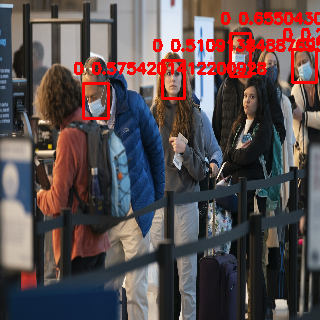

In [ ]:
out = do_inference(engine, im, h_input, d_input, h_output, d_output, stream, 1, HEIGHT, WIDTH)
# cv2_imshow(img)
show_detect(img , out)